In [ ]:
import sys
print(sys.executable)


/usr/bin/python3


In [ ]:
# library import
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import joblib

# preprocess & augmentation
import os
import cv2

# for colab notebooks
from google.colab.patches import cv2_imshow

# region proposal -> object detection
from sklearn.svm import LinearSVC

from sklearn.preprocessing import Normalizer
# from google.colab.patches import cv2_imshow


In [ ]:
# GPU cek
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[]


In [ ]:
print(tf.__version__)

2.19.0


### drive test

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


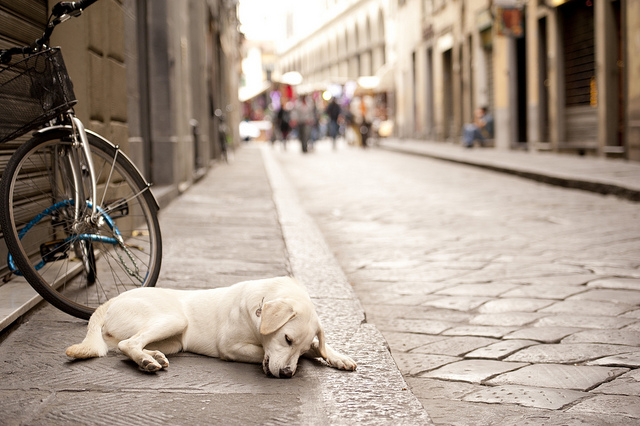

In [ ]:
test_img = cv2.imread('/content/drive/MyDrive/KULIAH/SEM-5/caption-generation/dog-example.jpg', cv2.IMREAD_UNCHANGED)
cv2_imshow(test_img)

# 1. Load COCO2017 - for collab

In [ ]:
from zipfile import ZipFile
import requests
import json

# progress bar
from tqdm import tqdm
import shutil

In [ ]:
# 1. buat directory
base_dir="./data/coco2017"

# struktur folder
os.makedirs(os.path.join(base_dir, "images", "train2017"), exist_ok=True)
os.makedirs(os.path.join(base_dir, "images", "val2017"), exist_ok=True)
os.makedirs(os.path.join(base_dir, "images", "annotations"), exist_ok=True)

print("Folder successfully created...")


Folder successfully created...


In [ ]:
urls = {
    "train_images": "http://images.cocodataset.org/zips/train2017.zip",
    "val_images": "http://images.cocodataset.org/zips/val2017.zip",
    "annotations": "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
}

download_dir = base_dir
subset_size= 50000

# download & extract
for name, url in urls.items():
  # print(name, url)
  zip_path = os.path.join(download_dir, f"{name}.zip")

  print(f"Donwload {name}...")
  response = requests.get(url, stream=True) #donwload bertahap(stream)
  with open(zip_path, 'wb') as f:
    for chunk in response.iter_content(chunk_size=1024):
      # pastikan write tdk empty
      if chunk:
        f.write(chunk)
  print(f"Download & extract {zip_path}...")

  with ZipFile(zip_path, 'r') as zip_ref:
    if "train" in name:
      zip_ref.extractall(os.path.join(base_dir, "images", "train2017"))
    elif "val" in name:
      zip_ref.extractall(os.path.join(base_dir, "images", "val2017"))
    else:
      zip_ref.extractall(os.path.join(base_dir, "annotations"))
  print(f"Extracted {name}")

print("process donwload & extract done.")

Donwload train_images...
Download & extract ./data/coco2017/train_images.zip...
Extracted train_images
Donwload val_images...
Download & extract ./data/coco2017/val_images.zip...
Extracted val_images
Donwload annotations...
Download & extract ./data/coco2017/annotations.zip...
Extracted annotations
process donwload & extract done.


In [ ]:
import json
base_dir="./data/coco2017"

annotation_path = os.path.join(base_dir, "annotations", "annotations","instances_train2017.json")
train_annot_path = "./data/coco2017/annotations/annotations/instances_train2017_subset.json"

with open(annotation_path, "r") as f:
    data = json.load(f)

print(data.keys())


dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])


In [ ]:
# get instances subset (JSON) - take 50ribu (10 rb an image)
annotation_path = os.path.join(base_dir, "annotations", "annotations","instances_train2017.json")
subset_path = os.path.join(base_dir, "annotations", "annotations","instances_train2017_subset.json")
subset_size=50000

if not os.path.exists(annotation_path):
  print(f"Error annot file not found = {annotation_path}")
else:
  with open(annotation_path, "r") as f:
    data=json.load(f)
  print(f"total annot asli : {len(data['annotations'])}")

  print(f"key in json: {data.keys()}")
  # subset
  subset_annot = data['annotations'][:subset_size]
  subset_category = data['categories']

  # ambil id gbr
  img_ids = set(ann["image_id"] for ann in subset_annot)
  subset_img_info = [img for img in data["images"] if img["id"] in img_ids]

  # simpan subset
  subset_data = {
      "info": data.get("info", {}),
      "licenses": data.get("licenses", []),
      "images": subset_img_info, # info image di subset
      "annotations": subset_annot,
      "categories": subset_category
  }

  os.makedirs(os.path.dirname(subset_path), exist_ok=True)
  with open(subset_path, "w") as f:
      json.dump(subset_data, f)

  print(f"Subset JSON dibuat: {subset_path}")
  print(f"tot img di subset info: {len(subset_img_info)} | Tot annotations: {len(subset_annot)}")

  # copy ke local source
  src_dir_option = os.path.join(base_dir, "images", "train2017", "train2017") # Common structure from zip

  src_dir = None
  if os.path.exists(src_dir_option) and len(os.listdir(src_dir_option)) > 0:
      src_dir = src_dir_option


  if src_dir:
      # destination directory
      dst_dir = os.path.join(base_dir, "images", "train2017_subset")
      os.makedirs(dst_dir, exist_ok=True)

      print(f"\nCopying subset image files from {src_dir} to {dst_dir}...")
      # Copy only file names present in the subset_images_info
      copied_count = 0
      # Create a set of file names to copy for faster lookup
      subset_image_filenames = {img_info["file_name"] for img_info in subset_img_info}

      # Iterate through files in the source directory and copy if they are in the subset
      for filename in tqdm(os.listdir(src_dir), desc="Checking & copying images"):
          if filename in subset_image_filenames:
                src_path = os.path.join(src_dir, filename)
                dst_path = os.path.join(dst_dir, filename)
                try:
                    shutil.copy(src_path, dst_path)
                    copied_count += 1
                except Exception as e:
                    print(f"Warning: Could not copy file {src_path} to {dst_path}: {e}")


      print(f"Finished copying. {copied_count} images copied to subset folder.")
      # Check if the number of copied files matches the number of images in the subset info
      if copied_count != len(subset_img_info):
          print(f"Warning: Number of copied files ({copied_count}) != subset info ({len(subset_img_info)}). Some source files might be missing.")

      print("Subset 50K image & annotations (locally copied images) ready")


total annot asli : 860001
key in json: dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])
Subset JSON dibuat: ./data/coco2017/annotations/annotations/instances_train2017_subset.json
tot img di subset info: 7920 | Tot annotations: 50000

Copying subset image files from ./data/coco2017/images/train2017/train2017 to ./data/coco2017/images/train2017_subset...


Checking & copying images: 100%|██████████| 118287/118287 [00:35<00:00, 3313.79it/s]

Finished copying. 7920 images copied to subset folder.
Subset 50K image & annotations (locally copied images) ready


In [ ]:
def load_coco_detection_pairs(img_dir, ann_path):
  with open(ann_path, 'r') as f:
    ann=json.load(f) # images, annotations bonding box, categories label

  # map img id -> filename
  images = {img['id']: img for img in ann['images']}

  # dict
  # pairs=[]
  grouped_pairs={}

  for item in ann['annotations']:
    img_id = item['image_id']
    # img_meta = images[item['image_id']]
    # img_path = os.path.join(img_dir, img_meta['file_name'])
    if img_id not in grouped_pairs:
      img_meta = images[img_id]
      img_path = os.path.join(img_dir, img_meta['file_name'])

      if os.path.exists(img_path):
        grouped_pairs[img_id]={
            "img": img_path,
            "boxes": [], #list boxes
            "labels": [] # list label
        }
      else:
        continue

    grouped_pairs[img_id]['boxes'].append(item['bbox'])
    grouped_pairs[img_id]['labels'].append(item['category_id'])

  pairs = list(grouped_pairs.values())
  return pairs

In [ ]:
import json

path = "./data/coco2017/annotations/annotations/instances_val2017.json"
train_annot_path = "./data/coco2017/annotations/annotations/instances_train2017_subset.json"

with open(train_annot_path, "r") as f:
    data_train = json.load(f)

print(data_train.keys())


dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])


In [ ]:
# 1. load coco pairs
train_annot_path = "./data/coco2017/annotations/annotations/instances_train2017_subset.json"
val_annot_path = "./data/coco2017/annotations/annotations/instances_val2017.json"

train_img_dir = "./data/coco2017/images/train2017_subset"
val_img_dir = "./data/coco2017/images/val2017/val2017"

train_pairs_detection = load_coco_detection_pairs(train_img_dir, train_annot_path)
val_pairs_detection = load_coco_detection_pairs(val_img_dir, val_annot_path)
print(train_pairs_detection[0])
print("Tot TRAIN detection pairs annot: ", len(train_pairs_detection))
print("Tot VAL detection pairs annot: ", len(val_pairs_detection))

# cek kategori ada brp
with open(train_annot_path, 'r') as f:
    ann=json.load(f)
categories = ann.get("categories", [])
print("Total categories: ", len(categories))

print("\n Sample category: ")
for cat in categories[:5]:
  print(f"{cat["id"]} : {cat["name"]}")

{'img': './data/coco2017/images/train2017_subset/000000558840.jpg', 'boxes': [[199.84, 200.46, 77.71, 70.88], [325.27, 104.38, 33.67, 105.99], [168.85, 90.98, 31.42, 88.73], [1.92, 87.91, 34.95, 175.35], [346.58, 1.07, 292.01, 343.71], [239.08, 42.72, 19.88, 76.73], [409.93, 215.42, 71.84, 50.12], [0.96, 1.02, 93.08, 160.25], [276.39, 13.81, 31.75, 61.57], [3.33, 263.96, 359.34, 156.39], [413.54, 201.9, 72.79, 56.38]], 'labels': [58, 44, 44, 47, 1, 44, 50, 1, 44, 67, 50]}
Tot TRAIN detection pairs annot:  7920
Tot VAL detection pairs annot:  4952
Total categories:  80

 Sample category: 
1 : person
2 : bicycle
3 : car
4 : motorcycle
5 : airplane


In [ ]:
# distribusi per id
from collections import Counter

list_ann = data["annotations"]

category_counts = Counter([a["category_id"] for a in list_ann])
print(f"Total kategori unik subset: {len(sorted(category_counts.items()))}")
print(f"Total sampel (annot) : {len(list_ann)}")

print("Total kategori subset : ", len(sorted(category_counts.items())))
for cid, count in sorted(category_counts.items()):
  print(f"Category {cid} : {count} sample")

Total kategori unik subset: 80
Total sampel (annot) : 860001
Total kategori subset :  80
Category 1 : 262465 sample
Category 2 : 7113 sample
Category 3 : 43867 sample
Category 4 : 8725 sample
Category 5 : 5135 sample
Category 6 : 6069 sample
Category 7 : 4571 sample
Category 8 : 9973 sample
Category 9 : 10759 sample
Category 10 : 12884 sample
Category 11 : 1865 sample
Category 13 : 1983 sample
Category 14 : 1285 sample
Category 15 : 9838 sample
Category 16 : 10806 sample
Category 17 : 4768 sample
Category 18 : 5508 sample
Category 19 : 6587 sample
Category 20 : 9509 sample
Category 21 : 8147 sample
Category 22 : 5513 sample
Category 23 : 1294 sample
Category 24 : 5303 sample
Category 25 : 5131 sample
Category 27 : 8720 sample
Category 28 : 11431 sample
Category 31 : 12354 sample
Category 32 : 6496 sample
Category 33 : 6192 sample
Category 34 : 2682 sample
Category 35 : 6646 sample
Category 36 : 2685 sample
Category 37 : 6347 sample
Category 38 : 9076 sample
Category 39 : 3276 sample
Ca

1 (person): 262465 samples
2 (bicycle): 7113 samples
3 (car): 43867 samples
4 (motorcycle): 8725 samples
5 (airplane): 5135 samples
6 (bus): 6069 samples
7 (train): 4571 samples
8 (truck): 9973 samples
9 (boat): 10759 samples
10 (traffic light): 12884 samples
11 (fire hydrant): 1865 samples
13 (stop sign): 1983 samples
14 (parking meter): 1285 samples
15 (bench): 9838 samples
16 (bird): 10806 samples
17 (cat): 4768 samples
18 (dog): 5508 samples
19 (horse): 6587 samples
20 (sheep): 9509 samples
21 (cow): 8147 samples
22 (elephant): 5513 samples
23 (bear): 1294 samples
24 (zebra): 5303 samples
25 (giraffe): 5131 samples
27 (backpack): 8720 samples
28 (umbrella): 11431 samples
31 (handbag): 12354 samples
32 (tie): 6496 samples
33 (suitcase): 6192 samples
34 (frisbee): 2682 samples
35 (skis): 6646 samples
36 (snowboard): 2685 samples
37 (sports ball): 6347 samples
38 (kite): 9076 samples
39 (baseball bat): 3276 samples
40 (baseball glove): 3747 samples
41 (skateboard): 5543 samples
42 (su

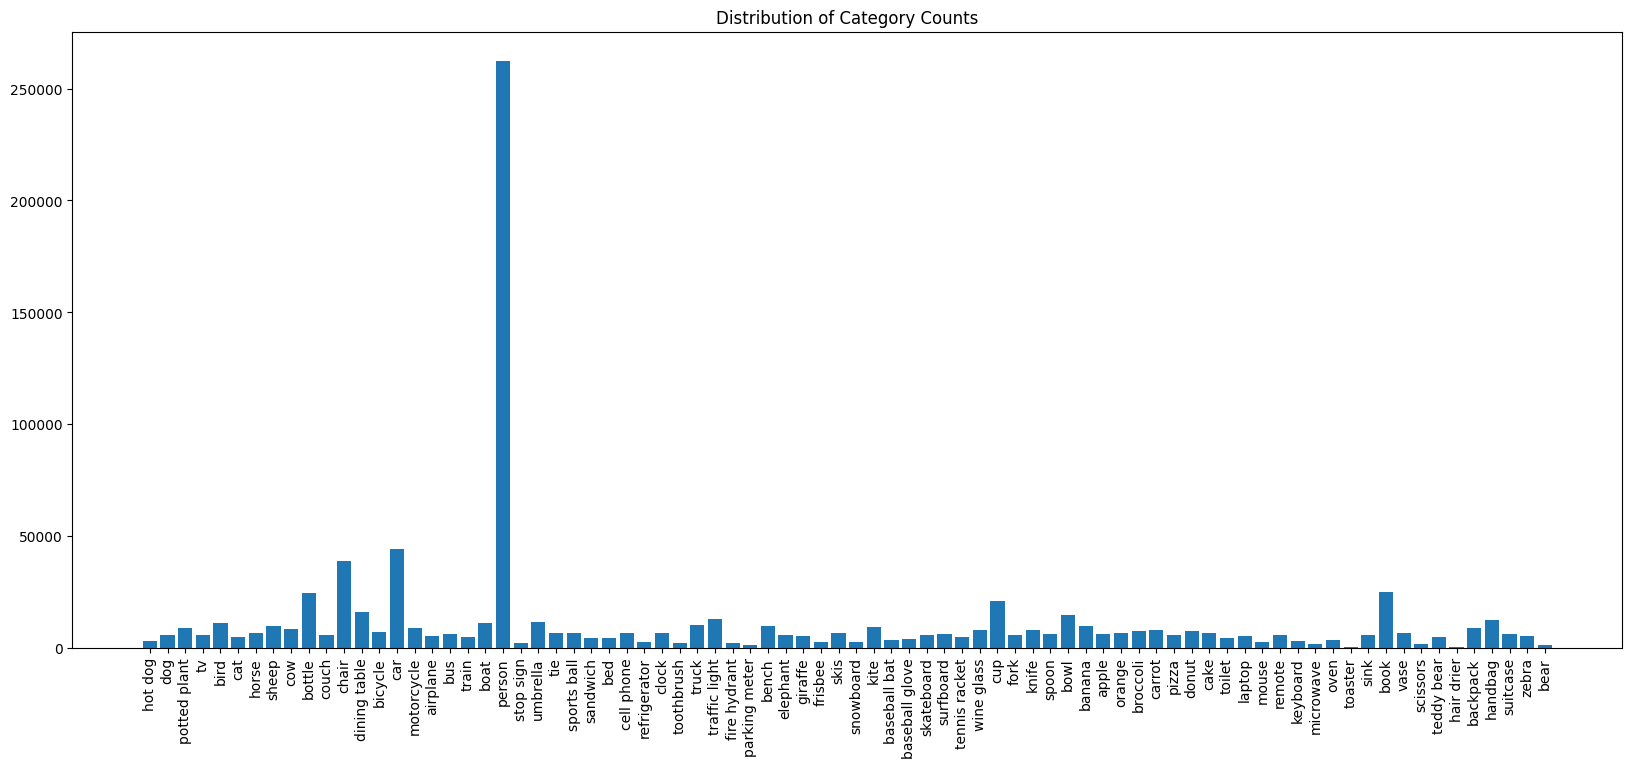

In [ ]:
id_to_name = {c["id"]: c["name"] for c in data["categories"]}

for cid, count in sorted(category_counts.items()):
    print(f"{cid} ({id_to_name[cid]}): {count} samples")

names = [id_to_name[cid] for cid in category_counts.keys()]
counts = [category_counts[cid] for cid in category_counts.keys()]

plt.figure(figsize=(20,8))
plt.bar(names, counts)
plt.xticks(rotation=90)
plt.title("Distribution of Category Counts")
plt.show()


In [ ]:
for i in range(3):
  print(train_pairs_detection[i])
  print(val_pairs_detection[i])

{'img': './data/coco2017/images/train2017_subset/000000558840.jpg', 'boxes': [[199.84, 200.46, 77.71, 70.88], [325.27, 104.38, 33.67, 105.99], [168.85, 90.98, 31.42, 88.73], [1.92, 87.91, 34.95, 175.35], [346.58, 1.07, 292.01, 343.71], [239.08, 42.72, 19.88, 76.73], [409.93, 215.42, 71.84, 50.12], [0.96, 1.02, 93.08, 160.25], [276.39, 13.81, 31.75, 61.57], [3.33, 263.96, 359.34, 156.39], [413.54, 201.9, 72.79, 56.38]], 'labels': [58, 44, 44, 47, 1, 44, 50, 1, 44, 67, 50]}
{'img': './data/coco2017/images/val2017/val2017/000000289343.jpg', 'boxes': [[473.07, 395.93, 38.65, 28.67], [204.01, 235.08, 60.84, 177.36], [0.43, 499.79, 339.79, 106.45], [204.42, 304.1, 52.51, 152.76]], 'labels': [18, 1, 15, 2]}
{'img': './data/coco2017/images/train2017_subset/000000200365.jpg', 'boxes': [[234.22, 317.11, 149.39, 38.55], [239.48, 347.87, 160.0, 57.81], [296.65, 388.33, 1.03, 0.0], [251.87, 333.42, 125.94, 22.71], [128.24, 192.99, 511.76, 281.33], [0.0, 36.05, 562.4, 443.74], [131.1, 0.0, 508.9, 24

In [ ]:
# type
sample= train_pairs_detection[0]

print("img_path: ", type(sample))
# print("bbox: ", type(sample[1]), "len: ", len(sample[1]))
# print("category: ", type(sample[2]))

img_path:  <class 'dict'>


# Image Classification (object centric based)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

### 1. one image - one max bbox area

In [ ]:
def detection_to_classification_pairs(detection_pairs):
  cls_pairs=[]

  for item in detection_pairs:
    boxes=item['boxes']
    labels = item['labels']

    if len(boxes)==0:
      continue

    # hitung area bbox
    areas=[w*h for (_,_,w,h) in boxes]

    # get bbox terbesar
    max_idx = np.argmax(areas)
    main_label = labels[max_idx]

    cls_pairs.append({
        "img": item['img'],
        "bbox": boxes[max_idx],
        "label": main_label
    })

  return cls_pairs

In [ ]:
train_pairs_cls = detection_to_classification_pairs(train_pairs_detection)
val_pairs_cls = detection_to_classification_pairs(val_pairs_detection)

print(train_pairs_cls[0])
print("Train cls size: ", len(train_pairs_cls))

{'img': './data/coco2017/images/train2017_subset/000000558840.jpg', 'bbox': [346.58, 1.07, 292.01, 343.71], 'label': 1}
Train cls size:  7920


In [ ]:
SELECTED_CLASS=[1,2,3,18]
# person, bicycle, car, dog

def filter_class(pairs, allowed_class):
  return [p for p in pairs if p["label"] in allowed_class]

# train_pairs_cls = balance_data(train_pairs_cls, 1, 50000)
train_pairs_cls = filter_class(train_pairs_cls, SELECTED_CLASS)
val_pairs_cls   = filter_class(val_pairs_cls, SELECTED_CLASS)
print(len(train_pairs_cls))
print(len(val_pairs_cls))

1773
1785


In [ ]:
print(train_pairs_cls[0])

{'img': './data/coco2017/images/train2017_subset/000000558840.jpg', 'bbox': [346.58, 1.07, 292.01, 343.71], 'label': 1}


### Save images (filtered)


In [ ]:
# BASE_OUT = "filtered_images"
# TRAIN_DIR = os.path.join(BASE_OUT, "train")
# VAL_DIR   = os.path.join(BASE_OUT, "val")

# for cls in SELECTED_CLASS:
#     os.makedirs(os.path.join(TRAIN_DIR, str(cls)), exist_ok=True)
#     os.makedirs(os.path.join(VAL_DIR, str(cls)), exist_ok=True)


In [ ]:
# import shutil

# def save_images_by_category(pairs, out_dir):
#     for p in pairs:
#         src   = p["img"]      # path ke train2017_subset/xxx.jpg
#         cid   = p["label"]    # category_id (1,2,3,18)

#         # BUAT folder category (ini yang sebelumnya hilang)
#         class_dir = os.path.join(out_dir, str(cid))
#         os.makedirs(class_dir, exist_ok=True)

#         filename = os.path.basename(src)
#         dst = os.path.join(class_dir, filename)

#         if not os.path.exists(dst):
#             shutil.copy(src, dst)

# save_images_by_category(train_pairs_cls, train_img_dir)
# save_images_by_category(val_pairs_cls, val_img_dir)


In [ ]:
# import os
# import shutil

# FILTERED_DIR = "./filtered_images"
# TRAIN_OUT = os.path.join(FILTERED_DIR, "train")
# VAL_OUT   = os.path.join(FILTERED_DIR, "val")

# def save_filtered_images(pairs, out_dir):
#     for p in pairs:
#         src = p["img"]        # contoh: ./data/coco2017/images/train2017_subset/xxx.jpg
#         cid = p["label"]      # category_id

#         # buat folder category
#         class_dir = os.path.join(out_dir, str(cid))
#         os.makedirs(class_dir, exist_ok=True)

#         filename = os.path.basename(src)
#         dst = os.path.join(class_dir, filename)

#         # copy hanya jika belum ada
#         if not os.path.exists(dst):
#             shutil.copy(src, dst)

# save_filtered_images(train_pairs_cls, TRAIN_OUT)
# save_filtered_images(val_pairs_cls, VAL_OUT)


In [ ]:
# import glob

# for cid in SELECTED_CLASS:
#     print(
#         f"Category {cid} |",
#         "Train:", len(glob.glob(f"{TRAIN_OUT}/{cid}/*.jpg")),
#         "| Val:", len(glob.glob(f"{VAL_OUT}/{cid}/*.jpg"))
#     )


In [ ]:
# shutil.make_archive("filtered_images", "zip", FILTERED_DIR)


### 2. Train (subset class : person, bicycle, car, dog)

In [ ]:
from collections import Counter
labels = [p["label"] for p in train_pairs_cls]

# Hitung distribusi
df = pd.DataFrame(train_pairs_cls)

# Hitung jumlah per kelas
counts = df['label'].value_counts().sort_index()

# Tambahkan label teks untuk kejelasan (opsional)
label_names = {1: "person", 2: "bicycle", 3: "car", 18: "dog"}
counts_df = counts.to_frame(name='Jumlah')
counts_df['Nama Kelas'] = counts_df.index.map(label_names)

print(counts_df)

       Jumlah Nama Kelas
label                   
1        1118     person
2         191    bicycle
3         383        car
18         81        dog


In [ ]:
# 2. encode label spy (0,1,2,3)

le = LabelEncoder()
train_labels = le.fit_transform([p["label"] for p in train_pairs_cls])
val_labels = le.transform([p["label"] for p in val_pairs_cls])

print(train_labels[:5])
print(val_labels)

[0 1 0 3 1]
[3 3 0 ... 0 0 0]


In [ ]:
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

In [ ]:
le = joblib.load("label_encoder.pkl")

# Tampilkan urutan kelasnya
print("Urutan kelas di SVM Anda:")
for i, class_name in enumerate(le.classes_):
    print(f"Index {i} -> Label: {class_name}")

Urutan kelas di SVM Anda:
Index 0 -> Label: 1
Index 1 -> Label: 2
Index 2 -> Label: 3
Index 3 -> Label: 18


### 3. Preprocess & feature extraction

In [ ]:
def apply_clahe(gray):
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  return clahe.apply(gray)


In [ ]:
def crop_object(img_path, bbox):
  img = cv2.imread(img_path)
  h_img, w_img = img.shape[:2]

  x,y,w,h = map(int, bbox) # Explicitly cast to int

  x=max(0,x)
  y=max(0,y)
  w=min(w, w_img-x)
  h=min(h, h_img-y)

  crop = img[y:y+h, x:x+w]
  return crop

# 1. crop & extract feature
def extract_hog_object_centric(img_path, bbox):
    crop= crop_object(img_path, bbox)
    crop = cv2.resize(crop, (224,224))
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    gray= apply_clahe(gray)


    hog_feat = hog(
        gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm="L2-Hys"
    )

    return hog_feat
    # return np.concatenate([hog_feat, lbp_hist])

In [ ]:
# 3. per image -> extract featurenya

X_train = [extract_hog_object_centric(p["img"], p["bbox"]) for p in train_pairs_cls]
X_val   = [extract_hog_object_centric(p["img"], p["bbox"]) for p in val_pairs_cls]

In [ ]:
print(len(X_train), X_train[0].shape)
# X_train = np.array(X_train, dtype=np.float32)

1773 (26244,)


In [ ]:
# normlaisasi
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [ ]:
joblib.dump(scaler, 'scaler76.pkl')

['scaler76.pkl']

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=256)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

In [ ]:
joblib.dump(pca, 'pca256.joblib')


['pca256.joblib']

In [ ]:
# # imbalance class
# smote = SMOTE(random_state=42)
# X_train_resample, train_labels_resample = smote.fit_resample(X_train, train_labels)
# print(f"Jumlah sampel sebelum SMOTE: {len(train_labels)}")
# print(f"Jumlah sampel setelah SMOTE: {len(train_labels_resample)}")


In [ ]:
# from imblearn.under_sampling import RandomUnderSampler
# from sklearn.svm import SVC

# rus = RandomUnderSampler(random_state=42)
# X_train_res, train_labels_res = rus.fit_resample(X_train, train_labels)
# print(f"Jumlah sampel setelah Undersampling: {len(train_labels_res)}")
# # Jumlah sampel sekarang akan jauh lebih kecil daripada 4472

# clf_rus = SVC(kernel='linear',C=1.0, max_iter=3000, probability=True)
# clf_rus.fit(X_train_res, train_labels_res) # under sampling


In [ ]:
# 4. train classifier
from sklearn.calibration import CalibratedClassifierCV

clf = LinearSVC(C=1.0,
                max_iter=5000,
                class_weight='balanced')
clf= CalibratedClassifierCV(clf, method='sigmoid')
clf.fit(X_train, train_labels)

CalibratedClassifierCV(estimator=LinearSVC(class_weight='balanced',
                                           max_iter=5000))

In [ ]:
# PCA
clf_pca = LinearSVC(C=1.0,
                max_iter=3000,
                class_weight='balanced')
clf_pca.fit(X_train_pca, train_labels)

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(class_weight='balanced', max_iter=3000)

In [ ]:
print(X_train_pca[0].shape, len(X_train_pca))

(256,) 1773


In [ ]:
val_preds = clf_pca.predict(X_val_pca)
print(classification_report(val_labels, val_preds, target_names=le.classes_.astype(str)))
# # hog (object centric with crop)
# ## PCA

              precision    recall  f1-score   support

           1       0.94      0.79      0.86      1589
           2       0.17      0.49      0.25        37
           3       0.24      0.63      0.35       102
          18       0.17      0.23      0.19        57

    accuracy                           0.76      1785
   macro avg       0.38      0.53      0.41      1785
weighted avg       0.86      0.76      0.80      1785



In [ ]:
y_train = [p["label"] for p in train_pairs_cls] # key "label"
y_val = [p["label"] for p in val_pairs_cls]

In [ ]:
val_preds = clf.predict(X_val)
print(classification_report(val_labels, val_preds, target_names=le.classes_.astype(str)))
# hog lbp (object centric with crop)
### with confidence

              precision    recall  f1-score   support

           1       0.91      0.97      0.94      1589
           2       1.00      0.22      0.36        37
           3       0.46      0.42      0.44       102
          18       0.00      0.00      0.00        57

    accuracy                           0.89      1785
   macro avg       0.59      0.40      0.43      1785
weighted avg       0.86      0.89      0.87      1785



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### save model

In [ ]:
import pickle

In [ ]:
# save
filename_pkl = "svc_singlepca76.pkl"
with open(filename_pkl, 'wb') as file:
    pickle.dump(clf_pca, file)

print(f"Model berhasil disimpan sebagai {filename_pkl}")



Model berhasil disimpan sebagai svc_singlepca76.pkl


### SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority', random_state=42)

# 3. Lakukan Oversampling
X_train_res, train_labels_res = smote.fit_resample(X_train, train_labels)

# Cek hasil (Output harusnya menunjukkan jumlah kelas minoritas meningkat)
print('Balanced dataset shape %s' % Counter(train_labels_res))

Balanced dataset shape Counter({np.int64(0): 1118, np.int64(3): 1118, np.int64(2): 383, np.int64(1): 191})


In [ ]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"Jumlah data setelah SMOTE: {Counter(y_train_res)}")

Jumlah data setelah SMOTE: Counter({1: 1118, 2: 1118, 18: 1118, 3: 1118})


In [ ]:
lsvc = LinearSVC(C=1.0, class_weight='balanced', dual=False, max_iter=2000)

# 2. Bungkus agar bisa mengeluarkan Probabilitas (untuk Confidence Score di Streamlit)
model_final = CalibratedClassifierCV(lsvc, method='sigmoid', cv=3)

# 3. Fit Model
model_final.fit(X_train_res, y_train_res)

# 4. Simpan model
joblib.dump(model_final, "svc_linear_final.pkl")

['svc_linear_final.pkl']

In [ ]:
# # 5. eval
# # balanced class & standardize (only hog)
# val_preds = clf.predict(X_val)
# print(classification_report(val_labels, val_preds, target_names=le.classes_.astype(str)))

#### predict image

In [ ]:
def predict_image(img_path, bbox, model, scaler=None, label_map=None):
  feat = extract_hog_object_centric(img_path, bbox)
  feat = feat.reshape(1, -1)

  if scaler is not None:
      feat = scaler.transform(feat)

  encoded_pred_label = model.predict(feat)[0]

  if label_map is not None:
      # Inverse transform the encoded label to get the original COCO ID
      original_coco_id = le.inverse_transform([encoded_pred_label])[0]
      return label_map[original_coco_id]

  return encoded_pred_label

./data/coco2017/images/train2017_subset/000000382406.jpg


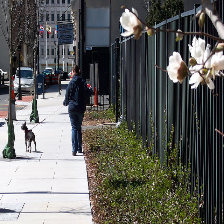

In [ ]:
img_path = train_pairs_cls[44]['img']

print(img_path)

img = cv2.imread(img_path)
img = cv2.resize(img, (224,224))
cv2_imshow(img)

In [ ]:
label_map = {
    1: "person",
    2: "bicycle",
    3: "car",
    18: "dog",
    10: "traffic light"
}

pred = predict_image(
    train_pairs_cls[10]['img'],
    train_pairs_cls[10]['bbox'], # Pass the bounding box
    clf,
    scaler=scaler,
    label_map=label_map
)

print("Predicted class:", pred)

Predicted class: person


## Inference

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.6 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
yolo=YOLO("yolov8n.pt") # nano utk bound box sj

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# 2. GET bbox YOLO
def get_bboxes_from_yolo(img_path, conf_thresh=0.25):
  results= yolo(img_path, conf=conf_thresh, verbose=False)
  detections=[]

  for r in results:
    if r.boxes is None:
      continue

    for box in r.boxes:
      x1,y1,x2,y2 = box.xyxy[0].cpu().numpy()

      w=x2-x1
      h=y2-y1

      detections.append({
          "bbox": (int(x1), int(y1), int(w), int(h)),
          "conf": float(box.conf[0])
      })

  return detections

# get luas terbesar / conf tertinggi
def select_largest_bbox(detections):
  if len(detections)==0:
    return None

  areas = [d["bbox"][2] * d["bbox"][3] for d in detections] # w*h
  # areas=[w*h for(x,y,w,h) in [d['bbox'] for d in detections]]
  idx=np.argmax(areas)
  return detections[idx]['bbox']

In [ ]:
# select best bounding box
def select_best_bbox(detections, allowed_class):
  candidates=[d for d in detections if d["label"] in allowed_class]
  if not candidates:
    return None
  return max(candidates, key=lambda d: d['conf']*d['area'])

In [ ]:
def predict_image_yolo_bbox(img_path, model, scaler=None, label_map=None):
  detections= get_bboxes_from_yolo(img_path)
  # bbox = select_largest_bbox(detections)
  bbox = select_best_bbox(detections, SELECTED_CLASS)

  if bbox is None:
    return "no object detected"

  feat = extract_hog_object_centric(img_path, bbox)
  assert feat.shape[0] == scaler.n_features_in_
  feat = feat.reshape(1,-1)
  if scaler is not None:
    feat = scaler.transform(feat)

  pred = model.predict(feat)[0]
  if label_map:
    return label_map[pred]

  return pred

In [ ]:
def predict_image_yolo_bbox_revised(img_path, model, clf, scaler=None, label_map=None):
    # 1. Dapatkan SEMUA deteksi dari YOLO (hanya bbox dan conf, belum ada label)
    all_detections = get_bboxes_from_yolo(img_path, conf_thresh=0.5) # Naikkan conf thresh yolo untuk hasil awal yg lebih bersih

    if not all_detections:
        return "no object detected"

    # 2. Iterasi melalui setiap deteksi dan dapatkan label dari CLASSIFIER MANUAL Anda
    candidates_with_labels = []
    for d in all_detections:
        bbox = d["bbox"]
        conf = d["conf"]

        # Ekstrak fitur manual Anda (HOG/LBP/SIFT/etc) dari area bbox ini
        feat = extract_hog_object_centric(img_path, bbox)

        # Pastikan shape benar untuk scaler/model
        assert feat.shape[0] == scaler.n_features_in_
        feat = feat.reshape(1,-1)

        if scaler is not None:
            feat = scaler.transform(feat)

        feat = pca.transform(feat)
        # Dapatkan prediksi dari MODEL MANUAL ANDA (clf)
        pred_index = clf.predict(feat)[0]
        predicted_label = label_map[pred_index] if label_map else pred_index

        # Tambahkan label prediksi ini ke kandidat
        candidates_with_labels.append({
            "bbox": bbox,
            "conf": conf,
            "label": predicted_label,
            "area": d["bbox"][2] * d["bbox"][3] # Hitung area
        })

    # 3. Filter kandidat berdasarkan SELECTED_CLASS yang Anda inginkan (misalnya, hanya 'person')
    # Di sinilah SELECTED_CLASS Anda digunakan
    filtered_candidates = [
        d for d in candidates_with_labels
        if d["label"] in SELECTED_CLASS # SELECTED_CLASS harus didefinisikan sebelumnya
    ]

    if not filtered_candidates:
        return "no target object found"

    # 4. Pilih yang terbaik dari kandidat yang difilter
    best_bbox_data = max(filtered_candidates, key=lambda d: d['conf'] * d['area'])

    # Kembalikan hanya label prediksi terbaik
    return best_bbox_data['label']

In [ ]:
def show_yolo_bbox(img_path, bbox, title="Detected Object"):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    x, y, w, h = bbox
    cv2.rectangle(
        img,
        (x, y),
        (x + w, y + h),
        (255, 0, 0),
        2
    )

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()


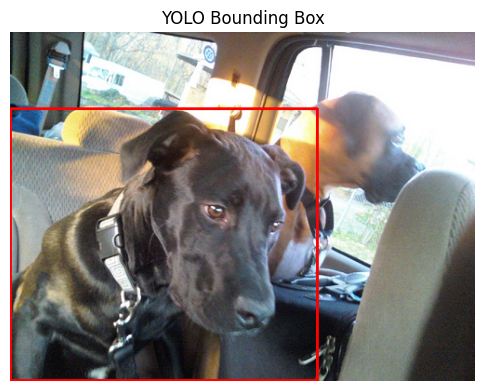

In [ ]:
path=train_pairs_cls[11]["img"]
detections = get_bboxes_from_yolo(path)
bbox = select_largest_bbox(detections)

show_yolo_bbox(
    path,
    bbox,
    title="YOLO Bounding Box"
)


In [ ]:
label_map = {
    0: "person",         # Encoded 0 is COCO ID 1
    1: "bicycle",        # Encoded 1 is COCO ID 2
    2: "car",            # Encoded 2 is COCO ID 3
    3: "dog",             # Encoded 3 is COCO ID 18
}
SELECTED_CLASS = ["person", "bicycle", "car","dog"]
img_path = train_pairs_cls[11]['img']

pred_label=predict_image_yolo_bbox_revised(
    img_path=img_path,
    model=yolo,
    clf=clf_pca,
    scaler=scaler,
    label_map=label_map
)
print(pred_label)

person


#### Non PCA

In [ ]:
def predict_image_yolo_bbox_noPCA(img_path, model, clf, scaler=None, label_map=None):
    # 1. Dapatkan SEMUA deteksi dari YOLO (hanya bbox dan conf, belum ada label)
    all_detections = get_bboxes_from_yolo(img_path, conf_thresh=0.5) # Naikkan conf thresh yolo untuk hasil awal yg lebih bersih

    if not all_detections:
        return "no object detected"

    # 2. Iterasi melalui setiap deteksi dan dapatkan label dari CLASSIFIER MANUAL Anda
    candidates_with_labels = []
    for d in all_detections:
        bbox = d["bbox"]
        conf = d["conf"]

        # Ekstrak fitur manual Anda (HOG/LBP/SIFT/etc) dari area bbox ini
        feat = extract_hog_object_centric(img_path, bbox)

        # Pastikan shape benar untuk scaler/model
        assert feat.shape[0] == scaler.n_features_in_
        feat = feat.reshape(1,-1)

        if scaler is not None:
            feat = scaler.transform(feat)

        # feat = pca.transform(feat)
        # Dapatkan prediksi dari MODEL MANUAL ANDA (clf)
        pred_index = clf.predict(feat)[0]
        predicted_label = label_map[pred_index] if label_map else pred_index

        # Tambahkan label prediksi ini ke kandidat
        candidates_with_labels.append({
            "bbox": bbox,
            "conf": conf,
            "label": predicted_label,
            "area": d["bbox"][2] * d["bbox"][3] # Hitung area
        })

    # 3. Filter kandidat berdasarkan SELECTED_CLASS yang Anda inginkan (misalnya, hanya 'person')
    # Di sinilah SELECTED_CLASS Anda digunakan
    filtered_candidates = [
        d for d in candidates_with_labels
        if d["label"] in SELECTED_CLASS # SELECTED_CLASS harus didefinisikan sebelumnya
    ]

    if not filtered_candidates:
        return "no target object found"

    # 4. Pilih yang terbaik dari kandidat yang difilter
    best_bbox_data = max(filtered_candidates, key=lambda d: d['conf'] * d['area'])

    # Kembalikan hanya label prediksi terbaik
    return best_bbox_data['label']

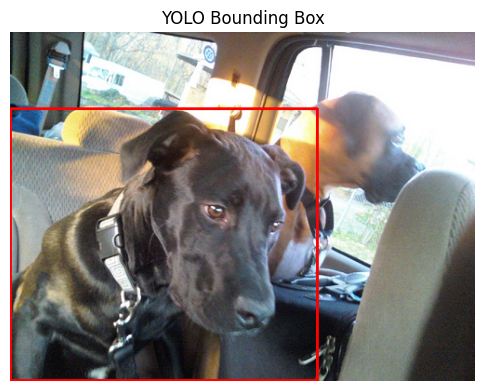

In [ ]:
path=train_pairs_cls[11]["img"]
detections = get_bboxes_from_yolo(path)
bbox = select_largest_bbox(detections)

show_yolo_bbox(
    path,
    bbox,
    title="YOLO Bounding Box"
)


In [ ]:
label_map = {
    0: "person",         # Encoded 0 is COCO ID 1
    1: "bicycle",        # Encoded 1 is COCO ID 2
    2: "car",            # Encoded 2 is COCO ID 3
    3: "dog",             # Encoded 3 is COCO ID 18
}
SELECTED_CLASS = ["person", "bicycle", "car","dog"]
img_path = train_pairs_cls[11]['img']

pred_label=predict_image_yolo_bbox_noPCA(
    img_path=img_path,
    model=yolo,
    clf=clf,
    scaler=scaler,
    label_map=label_map
)
print(pred_label)

person
